## 🖼 Working with image data in `Mosaic`

In [1]:
from mosaic import DataPanel, ImageColumn
import numpy as np

## 💾 Downloading the data.
First, we'll download some data to explore. We're going to use the [Imagenette dataset](https://github.com/fastai/imagenette#image%E7%BD%91), a small subset of the original [ImageNet](https://www.image-net.org/update-mar-11-2021.php).  This dataset is made up of 10 classes(e.g. "garbage truck", "gas pump", "golf ball").
- Download time: ~3 minutes
- Download size: 130M

In addition to downloading the data, `download_celeba` prepares a CSV, "imagenette.csv", with a row for each image. 

In [2]:
from mosaic.contrib.imagenette import download_imagenette

BASE_DIR = "/home/common/datasets"
dataset_dir = download_imagenette(BASE_DIR);

Directory /home/common/datasets/imagenette2-160 already exists. Skipping download.


## 📸 Creating an image `DataPanel`.

We're going to build a `DataPanel` out of the "imagenette.csv" file from the download above. 

1. Create a `DataPanel` from a CSV using the `DataPanel.from_csv` class method.
2. Create an `ImageColumn` from the the existing `"img_path"` column using the `DataPanel.from_filepaths` class method and add it to the the `DataPanel`. 

In [3]:
# 1. Create `DataPanel`
dp = DataPanel.from_csv(os.path.join(dataset_dir, "imagenette.csv"))
# 2. Create `ImageColumn`
dp["img"] = ImageColumn.from_filepaths(filepaths=dp["img_path"])
dp.head()

,img_path (NumpyArrayColumn),label (NumpyArrayColumn),label_id (NumpyArrayColumn),label_idx (NumpyArrayColumn),split (NumpyArrayColumn),index (ListColumn),img (ImageColumn)
0,/home/common/datasets/imagenette2-160/train/n0...,cassette player,n02979186,482,train,'0',ImagePathCell(n02979186_9036.JPEG)
1,/home/common/datasets/imagenette2-160/train/n0...,cassette player,n02979186,482,train,'1',ImagePathCell(n02979186_11957.JPEG)
2,/home/common/datasets/imagenette2-160/train/n0...,cassette player,n02979186,482,train,'2',ImagePathCell(n02979186_9715.JPEG)
3,/home/common/datasets/imagenette2-160/train/n0...,cassette player,n02979186,482,train,'3',ImagePathCell(n02979186_21736.JPEG)
4,/home/common/datasets/imagenette2-160/train/n0...,cassette player,n02979186,482,train,'4',ImagePathCell(ILSVRC2012_val_00046953.JPEG)


### 🗂 Indexing.
When we create an `ImageColumn` we don't load the images into memory. Instead, `ImageColumn` keeps track of all those filepaths we passed in and only loads the images when they are accessed. 

Indexing the `ImageColumn` returns an object of type: <class 'PIL.Image.Image'>.


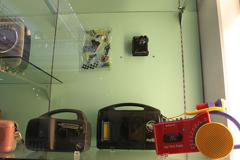

In [4]:
img = dp["img"][1]
print(f"Indexing the `ImageColumn` returns an object of type: {type(img)}.")
display(img)

We can load a **batch** of images by indexing a slice. Notice that the output is a `ListColumn` of PIL images. 

In [5]:
img = dp["img"][1:4]
print(f"Indexing a slice of the `ImageColumn` returns a: {type(img)}.")
display(img)

Indexing a slice of the `ImageColumn` returns a: <class 'mosaic.columns.list_column.ListColumn'>.


,(ListColumn)
0,<PIL.Image.Image image mode=RGB size=240x160 a...
1,<PIL.Image.Image image mode=RGB size=160x216 a...
2,<PIL.Image.Image image mode=RGB size=213x160 a...


### 🧫 _Aside_: `ImageColumn` under the hood, `CellColumn`.

If you check out the implementation of `ImageColumn` (at "mosaic/columns/image_column.py"), you'll notice that it's a super simple subclass of `CellColumn`. 

_What's a `CellColumn`?_
In `mosaic`, high-dimensional data types like images and videos are typically stored in a `CellColumn`. The advantage of using `CellColumn` (or one of its subclasses) is that we can easily create new column types (e.g. for medical volumes, SpacyDocs, or graphs) without dealing with the implementation complexity of a full column. Instead, we can think in terms of the individual elements in the column: the cells.  We implement a cell by subclassing `AbstractCell` and overriding the `get` method. `get` is called when the cell is accessed, like in the example above. Below is a simple implemenation of an `ImageCell` (the actual cell used by `ImageColumn` is `mosaic.cells.imagepath.ImagePath`, which has a few additional features not included here): 


```
from mosaic.cells.abstract import AbstractCell
from torchvision.datasets.folder import default_loader

class ImageCell(AbstractCell):

    def __init__(self, filepath: str):
        super(ImagePath, self).__init__()
        self.filepath = filepath

    def get(self, *args, **kwargs):
        return default_loader(self.filepath)
    
    @classmethod
    def _state_keys(cls) -> Collection:
        return {"filepath"}
```
Notice that the `default_loader` isn't called on construction, only on `get`. Additionally, we need to specify the "_state_keys", the set of object attributes needed to recreate the cell. When writing the cell to disk, only these attributes are written. 

### 🦥 Lazy indexing.
What if we don't want to load the images? To access the underlying cell (without loading the image), use the lazy indexer, `lz`.

In [6]:
cell = dp["img"].lz[8000]
print(f"Lazy indexing the `ImageColumn` returns an object of type: {type(cell)}.")
display(cell)

Lazy indexing the `ImageColumn` returns an object of type: <class 'mosaic.cells.imagepath.ImagePath'>.


ImagePathCell(n03445777_18428.JPEG)

Note: **cells can survive on their own.** Everything we need to materialize the cell (e.g. the filepath to the image and the loading function) lives inside the cell, so we can call `cell.get()` to load the image even after the cell has been isolated from it's original column. 

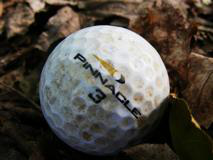

In [7]:
cell.get()

Using the lazy indexer and one of the following indexing schemes, we can also access a **subset** of a `CellColumn`, which is itself a `CellColumn`.
- **Slice indexing**: _e.g._ `column.lz[4:10]`
- **Integer array indexing**: _e.g._ `column.lz[[0,4, 6, 11]]`
- **Boolean array indexing**: _e.g._ `column.lz[np.array([True,False, False ..., True, False])]`

In [8]:
cells = dp["img"].lz[12:16]
print(f"Lazy indexing a slice of the `ImageColumn` returns an object of type: {type(cells)}.")
display(cells)

Lazy indexing a slice of the `ImageColumn` returns an object of type: <class 'mosaic.columns.image_column.ImageColumn'>.


,(ImageColumn)
0,ImagePathCell(n02979186_2733.JPEG)
1,ImagePathCell(n02979186_23069.JPEG)
2,ImagePathCell(n02979186_2467.JPEG)
3,ImagePathCell(n02979186_3293.JPEG)


## 🛠 Applying operations over the DataPanel.

When training and evaluating our models, we often perform operations on each example in our dataset (e.g. compute a model's prediction on each example, tokenize each sentence, compute a model's embedding for each example) and store them. The `DataPanel` makes it easy to perform these operations:  
- Produce new columns (via `DataPanel.map`)
- Produce new columns and store the columns alongside the original data (via `DataPanel.update`)
- Extract an important subset of the datset (via `DataPanel.filter`).   

Under the hood, dataloading is multiprocessed so that costly I/O doesn't bottleneck our computation.

Let's start by filtering the `DataPanel` down to the first 1,000 examples in the validation set. Note that we use the lazy indexer `lz` to avoid loading all of the images. 

In [9]:
valid_dp = dp.lz[dp["split"].data == "valid"]

### 🫐  Using `DataPanel.map` to compute average intensity of the blue color channel in the images.

To demonstrate the utility `map` operation, we'll explore the relationship between the "blueness" of an image and the class of the image. 

We'll quantify the "blueness" of each image by simply computing the mean intensity of the blue color channel. This can be accomplished with a simple `map` operation over the `DataPanel`:

In [10]:
blue_col = valid_dp.map(
    lambda x: np.array(x["img"])[:, :, 2].mean(), 
    pbar=True, 
    num_workers=4
)
valid_dp["avg_blue"] = blue_col  # add the intensities as a new column in the `DataPanel` 


🪂 vs. ⛳️
Next, we'll explore the relationship between blueness and the class label of the image. To do so, we'll compare the blue intensity distribution of images labeled "parachute" to the distribution of of images labeled "golf ball".
Using the [`seaborn`](https://seaborn.pydata.org/installing.html) plotting package and our `DataPanel`, this can be accomplished in one line: 

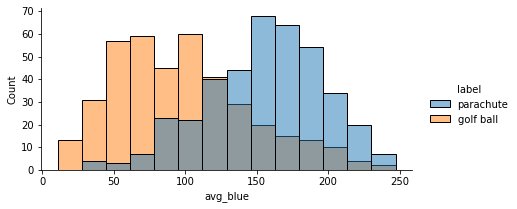

In [28]:
## OPTIONAL: this cell requires the seaborn dependency: https://seaborn.pydata.org/installing.html 
import seaborn as sns
plot_dp = valid_dp[np.isin(valid_dp["label"], ["golf ball", "parachute"])]
sns.displot(
    data=plot_dp.to_pandas(), 
    x="avg_blue", 
    hue="label", 
    height=3, 
    aspect=2
);

Looks like images of parachutes are quite a bit more blue than images of golf balls. To understand why this might be the case, we'll take a look at the image with the highest blue intensity:

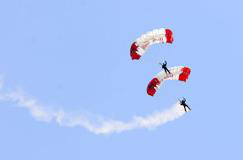

In [14]:
valid_dp["img"][int(np.argmax(valid_dp["avg_blue"]))]

Photos of parachutes usually have the sky behind them! Checks out that they're so blue...

## 📉 ML with images in `mosaic`.

Let's do some machine learning on our Imagenette `DataPanel`.
We'll take a resnet18 pretrained on the full ImageNet dataset, perform inference on the validation set, and analyze the model's predictions and activations. 

The cell below downloads the model.. 

In [11]:
import torch
from torchvision.models import resnet18
import torchvision.transforms as transforms
model = resnet18(pretrained=True)

### 💈  Creating an `ImageColumn"` with a transform.
In order to do inference, we'll need to create a _new_ `ImageColumn`. The `ImageColumn` we defined above (_i.e._ `"img_path"`), does not apply any transforms after loading and simply returns a PIL image. Before passing the images through the model, we need to convert the PIL image to a `torch.Tensor` and normalize the color channels (along with a few other transformations). 

Note: the transforms defined below are the same as the ones used by torchvision, see [here](https://github.com/pytorch/examples/blob/cbb760d5e50a03df667cdc32a61f75ac28e11cbf/imagenet/main.py#L225). 

In the cell below, we specify a transform when creating the `ImageColumn`.

In [12]:
# 1. Define transform
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
])

# 2. Create new column with transform 
valid_dp["input"] = ImageColumn.from_filepaths(
    filepaths=valid_dp["img_path"], 
    transform=transform,
)

Notice that indexing this new `ImageColumn` returns a `torch.Tensor`, not a PIL image...  

In [13]:
img = valid_dp["input"][0]
print(f"Indexing the `ImageColumn` returns an object of type: {type(img)}.")

Indexing the `ImageColumn` returns an object of type: <class 'torch.Tensor'>.


... and that indexing a slice of this new `ImageColumn` returns a `TensorColumn`, not a `ListColumn` of PIL images.

In [14]:
col = img = valid_dp["input"][:3]
print(f"Indexing a slice of the `ImageColumn` returns an object of type: {type(img)}.")
display(col)

Indexing a slice of the `ImageColumn` returns an object of type: <class 'mosaic.columns.tensor_column.TensorColumn'>.


,(TensorColumn)
0,"np.ndarray(shape=torch.Size([3, 224, 224]))"
1,"np.ndarray(shape=torch.Size([3, 224, 224]))"
2,"np.ndarray(shape=torch.Size([3, 224, 224]))"


### 💫 Computing model predictions and activations.
We'd like to perform inference and extract:
  
1. Output predictions  
2. Output class probabilities  
3. Model activations 

Note: in order to extract model activations, we'll need to use a [PyTorch forward hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) and register it on the final layer of the ResNet. Forward hooks are just functions that get executed on the forward pass of a `torch.nn.Module`. 

In [15]:
# 1. Define the forward hook
class ActivationExtractor:
    """Extracting activations a targetted intermediate layer"""

    def __init__(self):
        self.activation = None

    def forward_hook(self, module, input, output):
        self.activation = output

# 2. Register the forward hook
extractor = ActivationExtractor()
model.layer4.register_forward_hook(extractor.forward_hook);

We want to apply a forward pass to each image in the `DataPanel` and store the outputs as new columns: `DataPanel.update` is perfectly suited for this task. 

Like `map`, `update` accepts a function and applies it to batches of rows in the the `DataPanel`. Unlike `map`, `update` must return a dictionary. Each key in the dictionary corresponds to a new column that will be added to the updated `DataPanel`. 



In [16]:
# 1. Move the model to GPU
model.to(0).eval()

# 2. Define a function that runs a forwrd pass over a batch 
@torch.no_grad()
def predict(batch: DataPanel):
    input_col: mosaic.TensorColumn = batch["input"] 
    x: torch.Tensor = input_col.data.to(0)  # We get the underlying torch tensor with `data` and move to GPU 
    out: torch.Tensor = model(x)  # Run forward pass

    # Return a dictionary with one key for each of the new columns. Each value in the
    # dictionary should have the same length as the batch. 
    return {
        "pred": out.cpu().numpy().argmax(axis=-1),
        "probs": torch.softmax(out, axis=-1).cpu().numpy(),
        "activation": extractor.activation.mean(dim=[-1,-2]).cpu().numpy()
    }
# 3. Apply the update. Note that the `predict` function operates on batches, so we set 
# `batched=True`. Also, the `predict` function only accesses the "input" column, by 
# specifying that here we instruct update to only load that one column and skip others 
valid_dp = valid_dp.update(
    function=predict,
    batched=True,
    batch_size=32,
    input_columns=["input"], 
    pbar=True
)

The predictions, output probabilities, and activations are now stored alongside the examples in the `DataPanel`. 

In [17]:
valid_dp[["label_id", "input", "pred", "probs", "activation"]].head()

,label_id (NumpyArrayColumn),input (ImageColumn),pred (NumpyArrayColumn),probs (NumpyArrayColumn),activation (NumpyArrayColumn),index (ListColumn)
0,n02979186,ImagePathCell(n02979186_8971.JPEG),482,"np.ndarray(shape=(1000,))","np.ndarray(shape=(512,))",'9469'
1,n02979186,ImagePathCell(n02979186_14550.JPEG),754,"np.ndarray(shape=(1000,))","np.ndarray(shape=(512,))",'9470'
2,n02979186,ImagePathCell(n02979186_11971.JPEG),482,"np.ndarray(shape=(1000,))","np.ndarray(shape=(512,))",'9471'
3,n02979186,ImagePathCell(n02979186_11550.JPEG),482,"np.ndarray(shape=(1000,))","np.ndarray(shape=(512,))",'9472'
4,n02979186,ImagePathCell(n02979186_8751.JPEG),482,"np.ndarray(shape=(1000,))","np.ndarray(shape=(512,))",'9473'


### 🎯  Computing metrics and analyzing performance. 

Computing statistics on mosaic `DataPanels` is straightforward because standard NumPy operators and functions can be applied directly to a `NumpyArrayColumn`. We take advantage of this below to compute the accuracy of the model.

In [18]:
valid_dp["correct"] = valid_dp["pred"] == valid_dp["label_idx"]
accuracy = np.mean(valid_dp["correct"])
print(f"Micro accuracy across the ten Imagenette classes: {accuracy:0.3}")

Micro accuracy across the ten Imagenette classes: 0.671


Furthermore, since the `DataPanel` is naturally converted to a Pandas DataFrame, it's easy to use data visualization tools that interface with Pandas (_e.g._ seaborn, bokeh).

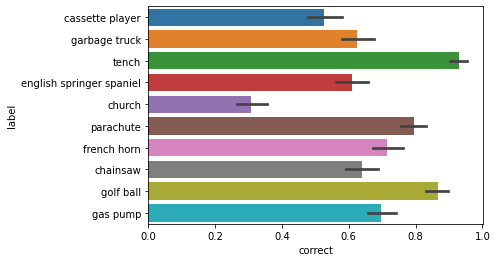

In [20]:
## OPTIONAL: this cell requires the seaborn dependency: https://seaborn.pydata.org/installing.html 
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(data=valid_dp.to_pandas(), y="label", x="correct");

### 🔎  Exploring model activations.
To better understand the behavior of our model, we'll explore the activations of the final convolutional layer of the ResNet. Recall that when we performed our forward pass, we extracted these activations and stored them in a new column called `"activation"`.

Unlike the the `NumpyArrayColumn`s we've been working with so far, the activation column has an additional dimension of size 512.

In [24]:
valid_dp["activation"][:4]

,(NumpyArrayColumn)
0,"np.ndarray(shape=(512,))"
1,"np.ndarray(shape=(512,))"
2,"np.ndarray(shape=(512,))"
3,"np.ndarray(shape=(512,))"


To visualize the activations, we'll use a dimensionality reduction technique ([UMAP](https://umap-learn.readthedocs.io/en/latest/)) to embed the activations in two dimensions. We'll store these embeddings in two new columns "umap_0" and "umap_1". 

In [14]:
## OPTIONAL: this cell requires the umap dependency: https://umap-learn.readthedocs.io/en/latest/
from umap import UMAP

# 1. Compute UMAP embedding
reducer = UMAP()
embs = reducer.fit_transform(valid_dp["activation"])

# 2. Add the embedding to the DataPanel as two new columns 
valid_dp["umap_0"] = embs[:, 0]
valid_dp["umap_1"] = embs[:, 1]

Again, we can leverage seaborn to quickly visualize the activations in a 2D scatter plot and color the points by the images label. The activations seem to cluster by the underlying label.  

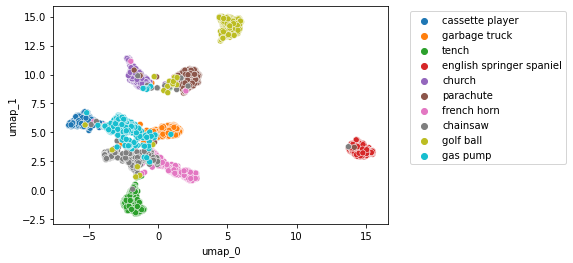

In [37]:
## OPTIONAL: this cell requires the seaborn dependency: https://seaborn.pydata.org/installing.html 
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=valid_dp.to_pandas(), x="umap_0", y="umap_1", hue="label");
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

## 💾  Writing a `DataPanel` to disk. 
Finally, we can write the updated `DataPanel`, with all the activations and predictions included, to disk for later use.  

In [26]:
valid_dp.write(os.path.join(dataset_dir, "valid_dp"))

In [27]:
valid_dp = DataPanel.read(os.path.join(dataset_dir, "valid_dp"))